# Supervised Learning (Classification) — Predictive Maintenance

**Dataset:** `predictive_maintenance_selected_features.csv` (synthetic)  
**Goal:** Predict machine failure (**Failure = 1**) using supervised classification models.

- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- Gradient Boosting (GBM)
- Naïve Bayes
- k-Nearest Neighbors (k-NN)

For **each model**, we will generate:
- Confusion Matrix
- Classification Report
- Accuracy, Precision, Recall, F1-Score
- ROC Curve + AUC
- Feature Importance (or a reasonable alternative)
- Predict on new data
- Save + Load models (Pickle)


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Feature importance alternatives
from sklearn.inspection import permutation_importance

# Saving & loading
import pickle
import joblib

pd.set_option("display.max_columns", None)


## Load dataset

In [2]:
df = pd.read_csv("predictive_maintenance_selected_features.csv")
df.head()


,Machine_ID,Vibration_RMS,Temperature_C,Motor_Current_A,Hours_Since_Maintenance,Asset_Age_Days,Load_Percent,Pressure_bar,Sound_dB,Humidity_%,Vib_Temp_Interaction,Failure_Risk_Score,Failure
0,1,1.918,63.19,15.77,605,868,79.26,7.91,59.76,45.15,121.19842,1,1
1,2,2.580,71.40,24.29,327,1288,99.66,7.67,73.61,54.31,184.21200,0,0
2,3,2.581,45.43,15.21,500,3146,23.28,7.56,68.47,49.48,117.25483,2,0
3,4,1.805,82.27,22.24,693,402,39.59,8.26,71.81,65.43,148.49735,2,0
4,5,1.961,51.94,19.83,34,422,67.82,4.06,76.15,64.95,101.85434,0,0


## Quick checks

In [3]:
print("Shape:", df.shape)
print("Missing values per column:\n", df.isna().sum())
print("\nTarget distribution (Failure):\n", df["Failure"].value_counts(normalize=True))


Shape: (5000, 13)
Missing values per column:
 Machine_ID                 0
Vibration_RMS              0
Temperature_C              0
Motor_Current_A            0
Hours_Since_Maintenance    0
Asset_Age_Days             0
Load_Percent               0
Pressure_bar               0
Sound_dB                   0
Humidity_%                 0
Vib_Temp_Interaction       0
Failure_Risk_Score         0
Failure                    0
dtype: int64

Target distribution (Failure):
 Failure
0    0.8444
1    0.1556
Name: proportion, dtype: float64


## Train-Test Split

We split into:
- **X** = features
- **y** = target (`Failure`)

We keep the failure ratio similar in train and test using `stratify=y`.


In [4]:
target = "Failure"

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (4000, 12) (4000,)
Test shape: (1000, 12) (1000,)


## Helper functions (Evaluation + ROC + Feature Importance)

Why we standardize for some models:
- Logistic Regression, SVM, and k-NN are sensitive to feature scale.
- Tree-based models (Decision Tree, Random Forest, GBM, XGBoost) usually do **not** require scaling.


In [5]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    return auc

def basic_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

def get_feature_importance(model, X_eval, y_eval, feature_names, top_n=12):
    """Return a Series of feature importance scores.
    
    Priority:
    1) Tree models: feature_importances_
    2) Logistic Regression: abs(coef_)
    3) Otherwise: permutation importance (model-agnostic)
    """
    # If this is a Pipeline, pull out the final estimator
    estimator = model
    if hasattr(model, "named_steps"):
        estimator = model.named_steps.get("model", model)
    
    if hasattr(estimator, "feature_importances_"):
        imp = pd.Series(estimator.feature_importances_, index=feature_names).sort_values(ascending=False)
        return imp.head(top_n)
    
    if hasattr(estimator, "coef_"):
        # For binary classification, coef_ shape: (1, n_features)
        coef = np.ravel(estimator.coef_)
        imp = pd.Series(np.abs(coef), index=feature_names).sort_values(ascending=False)
        return imp.head(top_n)
    
    # Permutation importance as fallback
    result = permutation_importance(model, X_eval, y_eval, n_repeats=10, random_state=42, scoring="f1")
    imp = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
    return imp.head(top_n)

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Fit, predict, evaluate, plot. Returns a dict of metrics and the fitted model."""
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Probabilities for ROC/AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models like SVM with probability=False, use decision_function and squish to 0..1
        scores = model.decision_function(X_test)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    
    print(f"\n===== {model_name} =====")
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    m = basic_metrics(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    m["AUC"] = auc
    
    print("Metrics:", {k: round(v, 4) for k, v in m.items()})
    
    plot_confusion_matrix(y_test, y_pred, title=f"{model_name} — Confusion Matrix")
    plot_roc_curve(y_test, y_proba, title=f"{model_name} — ROC Curve")
    
    # Feature importance
    feat_imp = get_feature_importance(model, X_test, y_test, X_test.columns, top_n=12)
    print("\nTop Feature Importance (or equivalent):")
    print(feat_imp)
    
    plt.figure(figsize=(7, 4))
    feat_imp.sort_values().plot(kind="barh")
    plt.title(f"{model_name} — Feature Importance (Top 12)")
    plt.xlabel("Importance")
    plt.show()
    
    return m, model


## 1) Logistic Regression


===== Logistic Regression =====
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.53      0.66       844
           1       0.18      0.55      0.27       156

    accuracy                           0.54      1000
   macro avg       0.52      0.54      0.46      1000
weighted avg       0.76      0.54      0.60      1000

Metrics: {'Accuracy': 0.535, 'Precision': 0.1788, 'Recall': 0.5513, 'F1': 0.27, 'AUC': 0.5868}


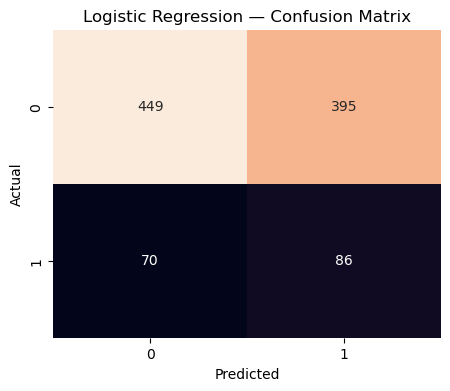

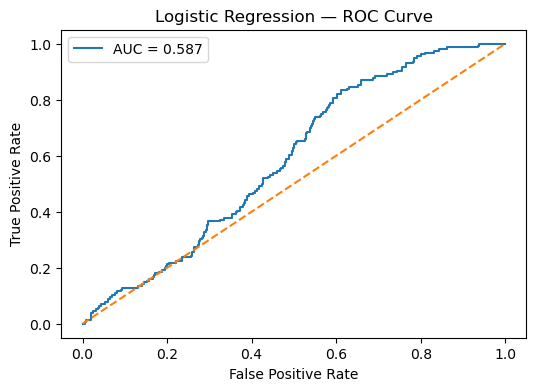


Top Feature Importance (or equivalent):
Asset_Age_Days             0.479955
Vib_Temp_Interaction       0.451622
Vibration_RMS              0.449286
Hours_Since_Maintenance    0.221337
Temperature_C              0.219118
Failure_Risk_Score         0.206808
Load_Percent               0.109268
Pressure_bar               0.065707
Humidity_%                 0.044301
Machine_ID                 0.042328
Motor_Current_A            0.013158
Sound_dB                   0.002047
dtype: float64


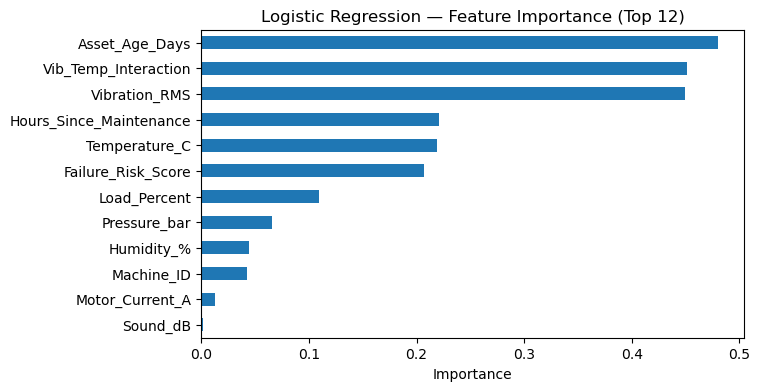

In [6]:
log_reg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

metrics_lr, fitted_lr = evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")


## 2) Decision Tree Classifier


===== Decision Tree =====
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.45      0.59       844
           1       0.18      0.64      0.28       156

    accuracy                           0.48      1000
   macro avg       0.52      0.54      0.43      1000
weighted avg       0.76      0.48      0.54      1000

Metrics: {'Accuracy': 0.477, 'Precision': 0.1764, 'Recall': 0.641, 'F1': 0.2766, 'AUC': 0.5459}


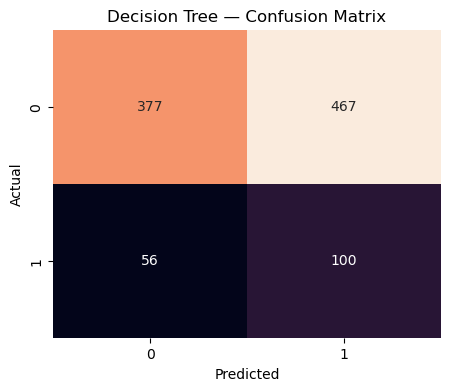

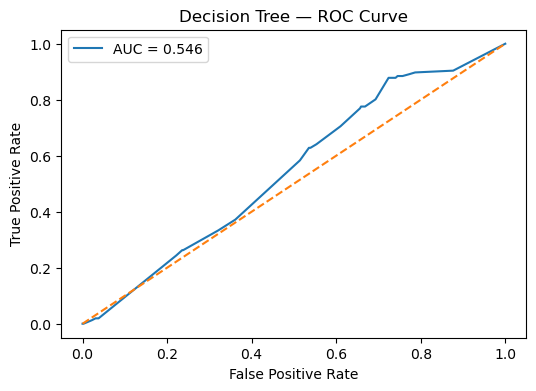


Top Feature Importance (or equivalent):
Asset_Age_Days             0.243832
Vib_Temp_Interaction       0.140327
Hours_Since_Maintenance    0.109764
Sound_dB                   0.102225
Temperature_C              0.091699
Humidity_%                 0.090799
Motor_Current_A            0.074816
Pressure_bar               0.051022
Load_Percent               0.050563
Machine_ID                 0.027091
Vibration_RMS              0.017861
Failure_Risk_Score         0.000000
dtype: float64


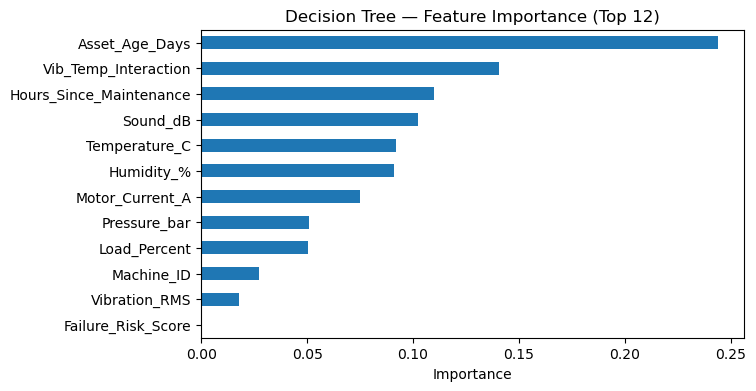

In [7]:
dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=20,
    class_weight="balanced",
    random_state=42
)

metrics_dt, fitted_dt = evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")


## 3) Random Forest Classifier


===== Random Forest =====
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.92       844
           1       0.00      0.00      0.00       156

    accuracy                           0.84      1000
   macro avg       0.42      0.50      0.46      1000
weighted avg       0.71      0.84      0.77      1000

Metrics: {'Accuracy': 0.844, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'AUC': 0.6154}


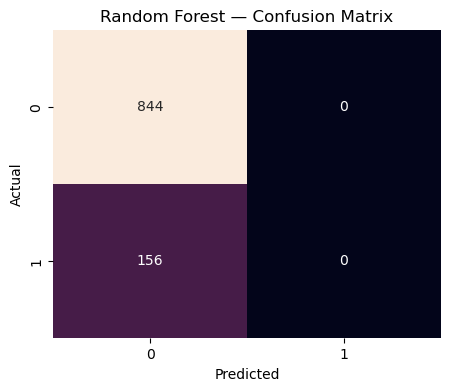

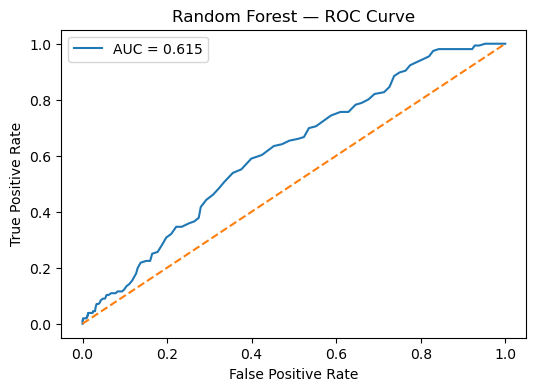


Top Feature Importance (or equivalent):
Asset_Age_Days             0.119372
Sound_dB                   0.090163
Humidity_%                 0.088611
Hours_Since_Maintenance    0.088047
Pressure_bar               0.086827
Vib_Temp_Interaction       0.086092
Machine_ID                 0.085467
Load_Percent               0.084954
Motor_Current_A            0.084033
Vibration_RMS              0.083563
Temperature_C              0.081940
Failure_Risk_Score         0.020930
dtype: float64


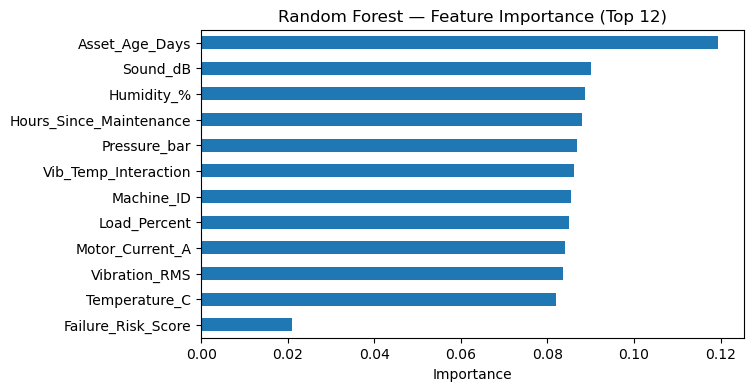

In [8]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

metrics_rf, fitted_rf = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")


## 4) Support Vector Machine (SVM)


===== SVM (RBF Kernel) =====
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.59      0.70       844
           1       0.18      0.49      0.26       156

    accuracy                           0.58      1000
   macro avg       0.52      0.54      0.48      1000
weighted avg       0.76      0.58      0.63      1000

Metrics: {'Accuracy': 0.576, 'Precision': 0.181, 'Recall': 0.4872, 'F1': 0.2639, 'AUC': 0.5902}


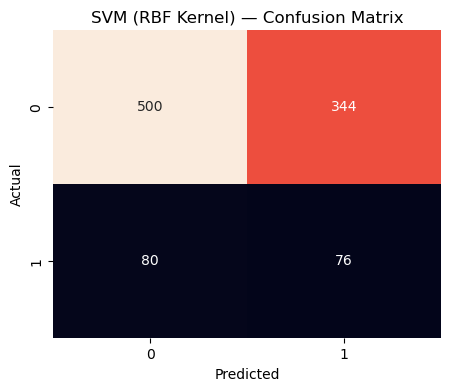

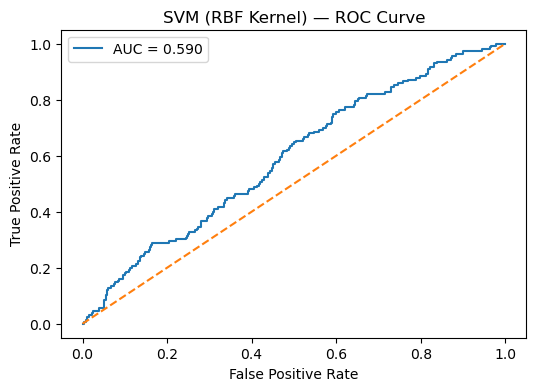

In [ ]:
svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", C=2.0, gamma="scale", probability=True, class_weight="balanced", random_state=42))
])

metrics_svm, fitted_svm = evaluate_model(svm, X_train, y_train, X_test, y_test, "SVM (RBF Kernel)")


## 5) Gradient Boosting Model (GBM) — sklearn

In [ ]:
gbm = GradientBoostingClassifier(random_state=42)
metrics_gbm, fitted_gbm = evaluate_model(gbm, X_train, y_train, X_test, y_test, "Gradient Boosting (sklearn)")


## 6) Naïve Bayes

In [ ]:
nb_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", GaussianNB())
])

metrics_nb, fitted_nb = evaluate_model(nb_model, X_train, y_train, X_test, y_test, "Naïve Bayes (Gaussian)")


## 7) k-Nearest Neighbors (k-NN)

In [ ]:
knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=15))
])

metrics_knn, fitted_knn = evaluate_model(knn, X_train, y_train, X_test, y_test, "k-NN")


## Compare model metrics

In [ ]:
results = []

def add_result(name, metrics_dict):
    row = {"Model": name}
    row.update(metrics_dict)
    results.append(row)

add_result("Logistic Regression", metrics_lr)
add_result("Decision Tree", metrics_dt)
add_result("Random Forest", metrics_rf)
add_result("SVM", metrics_svm)
add_result("Gradient Boosting (sklearn)", metrics_gbm)
add_result("Naïve Bayes", metrics_nb)
add_result("k-NN", metrics_knn)

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df


## Predict new data

We'll take a few rows from `X_test` as if they are “new incoming readings” from the plant,
then predict:
- class (0/1)
- probability of failure (where supported)


In [ ]:
best_model = fitted_rf  # change this to fitted_xgb / fitted_gbm / etc. if you prefer

new_data = X_test.sample(5, random_state=42) # randomly selects 5 rows from X_test and stores them in a new DataFrame called new_data
print("New data sample:")
display(new_data)

pred_class = best_model.predict(new_data)

if hasattr(best_model, "predict_proba"):
    pred_proba = best_model.predict_proba(new_data)[:, 1]
else:
    pred_proba = None

print("\nPredicted class:", pred_class)
if pred_proba is not None:
    print("Predicted failure probability:", np.round(pred_proba, 3))


## Saving and Loading Models (Pickle)

In [ ]:
# Save a fitted model
pickle_path = "best_model_pickle.pkl"

with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)


print("Saved:", pickle_path)


In [ ]:
# Load models back
with open("best_model_pickle.pkl", "rb") as f:
    loaded_pickle_model = pickle.load(f)


# Quick sanity check: predictions should match
pred1 = loaded_pickle_model.predict(new_data)

print("Loaded Pickle predictions:", pred1)